# Regresja logistyczna
Łukasz Klimkiewicz, 244822

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Numer indeksu
index = 244822

In [3]:
# Wartości pochodne
seed = index
n_samples = int(str(index)[0:2] + str(index)[-2:])
print(f'seed: {seed}; samples: {n_samples}')

seed: 244822; samples: 2422


## Implementacja regresji logistycznej

In [70]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator
from numpy import linalg
from scipy.sparse import issparse

class CustomLogisticRegression(BaseEstimator, ClassifierMixin):

    def __init__(self, fit_intercept=True, tol=1e-4, max_iter=100, learning_rate=1e-1):
        self.fit_intercept = fit_intercept
        self.tol = tol
        self.max_iter = max_iter
        self.learning_rate = learning_rate

        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):

        # reshape y
        y = y.reshape(-1, 1)

        # random parameters
        self.coef_ = np.random.randn(X.shape[1], 1)
        if self.fit_intercept:
            self.intercept_ = np.random.randn(1)[0]

        if issparse(X):
            X = X.A

        # add ones column
        if self.fit_intercept:
            X = np.hstack([X, np.ones((X.shape[0], 1))])

        # gradient descent
        for i in range(self.max_iter):
            weights_delta = self._learn_epoch(X, y)
            if np.all(np.abs(weights_delta) < self.tol):
                break

        return self

    def _learn_epoch(self, X, Y):
        weights_before = self._w.copy()
        for x, y in zip(X, Y):
            self._learn_sample(x, y)
        weights_delta = self._w - weights_before
        return weights_delta

    def _learn_sample(self, x, y):
        x = x.reshape(-1, 1)
        log = self._logistic_function(np.squeeze(x.T@self._w))
        gradient = (log - y) * x
        delta_w = -self.learning_rate * gradient
        self._w += delta_w

    def decision_function(self, X):
        result = X@self.coef_
        if self.fit_intercept:
            result += self.intercept_
        result = self._logistic_function(result)
        return result.ravel()

    def predict(self, X):
        return (self.decision_function(X) > 0.5).astype(np.int_)

    def _logistic_function(self, t):
        return 1 / (1 + np.exp(-t))

    @property
    def _w(self):
        if self.fit_intercept:
            return np.vstack([self.coef_, self.intercept_])
        else:
            return self.coef_

    @_w.setter
    def _w(self, value):
        if self.fit_intercept:
            self.coef_, self.intercept_ = np.vsplit(value, [-1])
        else:
            self.coef_ = value

## Ocena 3

### Pierwszy zbiór

#### Generowanie danych

In [5]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generowanie
syn1_x, syn1_y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, 
                                     n_repeated=0, n_clusters_per_class=1, random_state=index)

# Podział na zbiory
syn1_train_x, syn1_test_x, syn1_train_y, syn1_test_y = train_test_split(syn1_x, syn1_y, test_size=.2, random_state=seed)

# Strukturyzacja
syn1_data = {
    'train': {
        'x': syn1_train_x,
        'y': syn1_train_y
    },
    'test': {
        'x': syn1_test_x,
        'y': syn1_test_y
    }
}

#### Wizualizacja danych

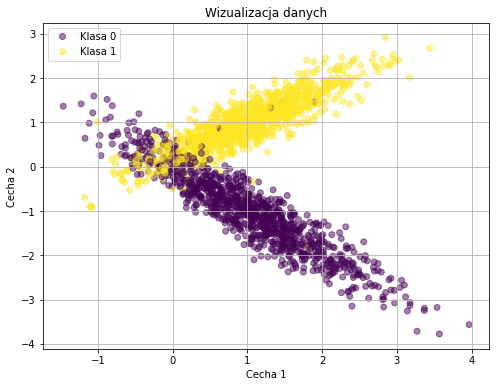

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(syn1_data['train']['x'][:,0], syn1_data['train']['x'][:,1], c=syn1_data['train']['y'], alpha=0.5)
ax.set_xlabel('Cecha 1')
ax.set_ylabel('Cecha 2')
ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
ax.grid()
ax.set_title('Wizualizacja danych');

#### Nauka

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

custom_model_syn1 = make_pipeline(
    MinMaxScaler(),
    CustomLogisticRegression(fit_intercept=True, max_iter=250, learning_rate=1e-2, tol=1e-7)
)

scikit_model_syn1 = make_pipeline(
    MinMaxScaler(),
    LogisticRegression(penalty='none', solver='newton-cg', fit_intercept=True)
)

custom_model_syn1.fit(syn1_data['train']['x'], syn1_data['train']['y'])

scikit_model_syn1.fit(syn1_data['train']['x'], syn1_data['train']['y']);

#### Wizualizacja powierzchni decyzyjnej

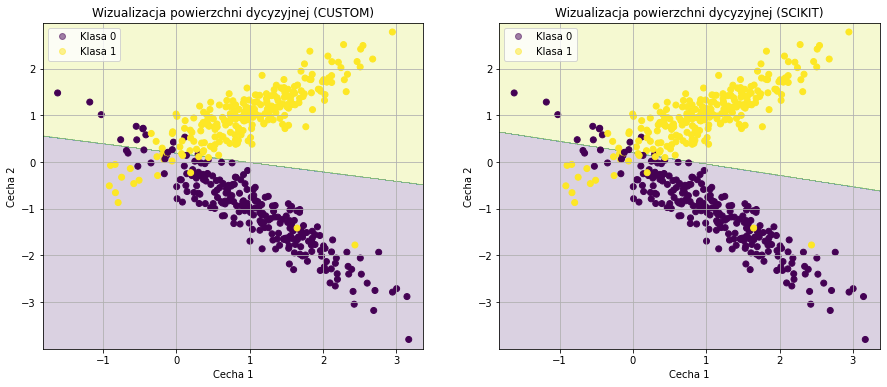

In [72]:
from sklearn.utils.extmath import cartesian

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

data = syn1_data['test']

margin = 0.2
x1 = data['x'][:,0].min() - margin
x2 = data['x'][:,0].max() + margin
y1 = data['x'][:,1].min() - margin
y2 = data['x'][:,1].max() + margin

for model, name, ax in (
    (custom_model_syn1, 'custom', axs[0]),
    (scikit_model_syn1, 'scikit', axs[1]),
):
    space_syn1 = np.meshgrid(np.linspace(x1, x2, 1000), np.linspace(y1, y2, 1000))
    predictions_syn1 = model.predict(np.dstack([*space_syn1]).reshape(-1, 2)).reshape(1000, 1000)

    ax.contourf(space_syn1[0], space_syn1[1], predictions_syn1, alpha=0.2)
    ax.scatter(data['x'][:,0], data['x'][:,1], c=data['y']);

    ax.set_xlabel('Cecha 1')
    ax.set_ylabel('Cecha 2')
    ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
    ax.set_title(f'Wizualizacja powierzchni dycyzyjnej ({name.upper()})');
    ax.grid()

#### Macierz przekłamań

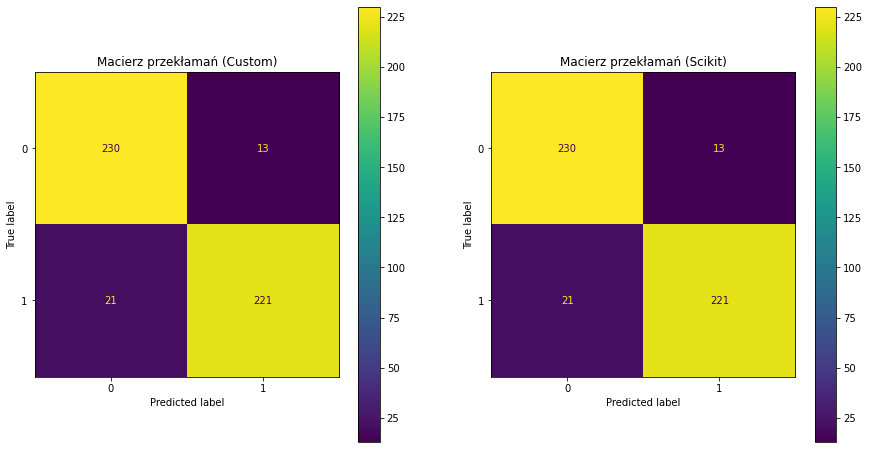

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay

data = syn1_data['test']
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
ax_c, ax_s = axs

ConfusionMatrixDisplay.from_estimator(custom_model_syn1, data['x'], data['y'], ax=ax_c)
ConfusionMatrixDisplay.from_estimator(scikit_model_syn1, data['x'], data['y'], ax=ax_s)

ax_c.set_title('Macierz przekłamań (Custom)')
ax_s.set_title('Macierz przekłamań (Scikit)');

#### Metryki

In [29]:
from sklearn.metrics import recall_score

# Obliczanie metryk
data = syn1_data['test']

sens_list = []
spec_list = []

for model in [custom_model_syn1, scikit_model_syn1]:

    predictions = model.predict(data['x'])

    sens = recall_score(data['y'], predictions)
    spec = recall_score(data['y'], predictions, pos_label=0)

    sens_list.append(sens)
    spec_list.append(spec)

# Tworzenie tabeli
pd.DataFrame({'Sensitivity': sens_list, 'Specificity': spec_list}, index=['Custom', 'Scikit'])

,Sensitivity,Specificity
Custom,0.913223,0.946502
Scikit,0.913223,0.946502


#### Krzywa ROC

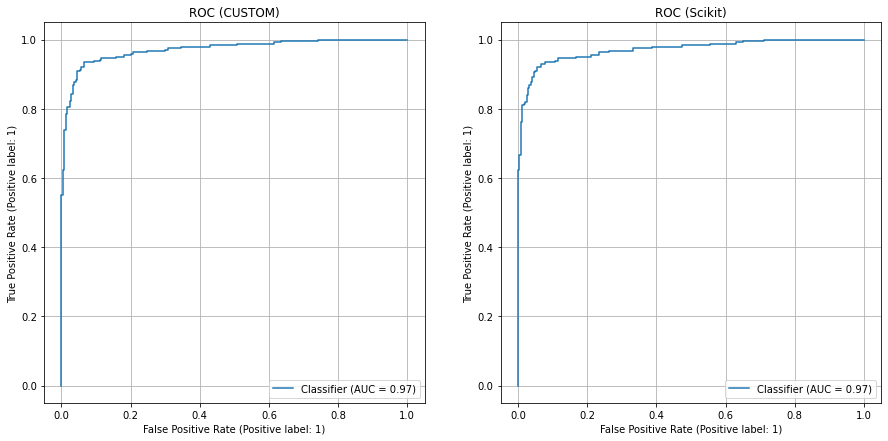

In [30]:
from sklearn.metrics import RocCurveDisplay

data = syn1_data['test']
fig, axs = plt.subplots(1, 2, figsize=(15,7))
ax_c, ax_s = axs

predictions_c = custom_model_syn1.decision_function(data['x'])
predictions_s = scikit_model_syn1.decision_function(data['x'])

RocCurveDisplay.from_predictions(data['y'], predictions_c, ax=ax_c)
RocCurveDisplay.from_predictions(data['y'], predictions_s, ax=ax_s)

ax_c.set_title('ROC (CUSTOM)')
ax_s.set_title('ROC (Scikit)')

ax_c.grid()
ax_s.grid()

#### Czasy

In [31]:
# Pomiar czasów
from sklearn.base import clone
import timeit

custom_model_time = clone(custom_model_syn1)
scikit_model_time = clone(scikit_model_syn1)

def time_custom_fit():
    custom_model_time.fit(syn1_data['train']['x'], syn1_data['train']['y'])

def time_custom_predict():
    custom_model_time.predict(syn1_data['test']['x'])

def time_scikit_fit():
    scikit_model_time.fit(syn1_data['train']['x'], syn1_data['train']['y'])

def time_scikit_predict():
    scikit_model_time.predict(syn1_data['test']['x'])


time_cf = timeit.timeit(time_custom_fit, number=1) / 1
time_cp = timeit.timeit(time_custom_predict, number=1000) / 1000
time_sf = timeit.timeit(time_scikit_fit, number=1000) / 1000
time_sp = timeit.timeit(time_scikit_predict, number=1000) / 1000

time_df = pd.DataFrame({'Nauka': [time_cf, time_sf], 'Przewidywanie': [time_cp, time_sp]}, index=['Custom', 'Scikit'])
time_df

,Nauka,Przewidywanie
Custom,13.559424,0.000069
Scikit,0.007033,0.000097


### Drugi zbiór

#### Generowanie danych

In [32]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Generowanie
syn2_x, syn2_y = make_moons(n_samples=n_samples, random_state=seed)

# Podział na zbiory
syn2_train_x, syn2_test_x, syn2_train_y, syn2_test_y = train_test_split(syn2_x, syn2_y, test_size=.2, random_state=seed)

# Strukturyzacja
syn2_data = {
    'train': {
        'x': syn2_train_x,
        'y': syn2_train_y,
    },
    'test': {
        'x': syn2_test_x,
        'y': syn2_test_y,
    }
}

#### Wizualizacja danych

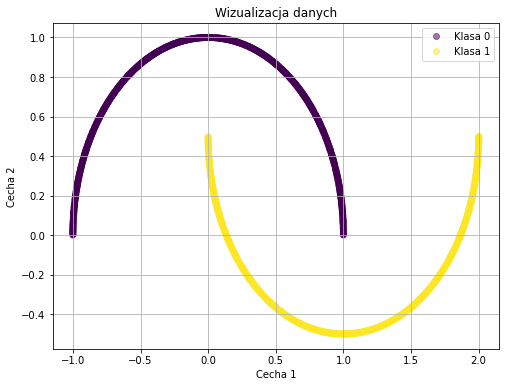

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(syn2_data['train']['x'][:,0], syn2_data['train']['x'][:,1], c=syn2_data['train']['y'], alpha=0.5)
ax.set_xlabel('Cecha 1')
ax.set_ylabel('Cecha 2')
ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
ax.grid()
ax.set_title('Wizualizacja danych');

#### Nauka

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

custom_model_syn2 = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=3, include_bias=False),
    CustomLogisticRegression(max_iter=100, learning_rate=4)
)

scikit_model_syn2 = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=3, include_bias=False),
    LogisticRegression(penalty='none', solver='newton-cg', max_iter=1000)
)

custom_model_syn2.fit(syn2_data['train']['x'], syn2_data['train']['y'])

scikit_model_syn2.fit(syn2_data['train']['x'], syn2_data['train']['y']);

#### Wizualizacja powierzchni decyzyjnej

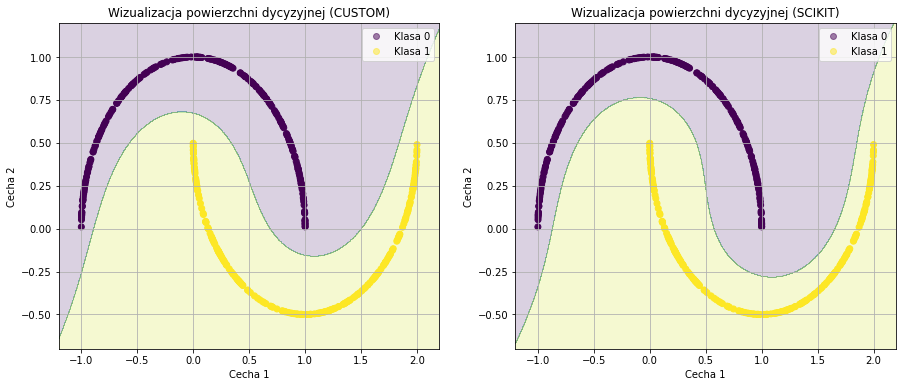

In [45]:
from sklearn.utils.extmath import cartesian

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

data = syn2_data['test']

margin = 0.2
x1 = data['x'][:,0].min() - margin
x2 = data['x'][:,0].max() + margin
y1 = data['x'][:,1].min() - margin
y2 = data['x'][:,1].max() + margin

for model, name, ax in (
    (custom_model_syn2, 'custom', axs[0]),
    (scikit_model_syn2, 'scikit', axs[1]),
):
    space_syn2 = np.meshgrid(np.linspace(x1, x2, 1000), np.linspace(y1, y2, 1000))
    predictions_syn2 = model.predict(np.dstack([*space_syn2]).reshape(-1, 2)).reshape(1000, 1000)

    ax.contourf(space_syn2[0], space_syn2[1], predictions_syn2, alpha=0.2)
    ax.scatter(data['x'][:,0], data['x'][:,1], c=data['y']);

    ax.set_xlabel('Cecha 1')
    ax.set_ylabel('Cecha 2')
    ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
    ax.set_title(f'Wizualizacja powierzchni dycyzyjnej ({name.upper()})');
    ax.grid()

#### Macierz przekłamań

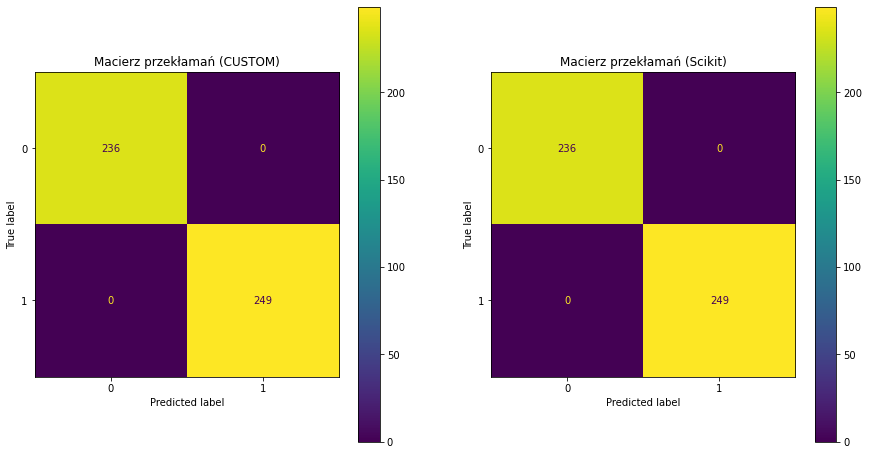

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay

data = syn2_data['test']
fig, axs = plt.subplots(1, 2, figsize=(15,8))
ax_c, ax_s = axs

ConfusionMatrixDisplay.from_estimator(custom_model_syn2, data['x'], data['y'], ax=ax_c)
ConfusionMatrixDisplay.from_estimator(scikit_model_syn2, data['x'], data['y'], ax=ax_s)

ax_c.set_title('Macierz przekłamań (CUSTOM)')
ax_s.set_title('Macierz przekłamań (Scikit)');

#### Metryki

In [47]:
from sklearn.metrics import recall_score

# Obliczanie metryk
data = syn2_data['test']

sens_list = []
spec_list = []

for model in [custom_model_syn2, scikit_model_syn2]:

    predictions = model.predict(data['x'])

    sens = recall_score(data['y'], predictions)
    spec = recall_score(data['y'], predictions, pos_label=0)

    sens_list.append(sens)
    spec_list.append(spec)

# Tworzenie tabeli
pd.DataFrame({'Sensitivity': sens_list, 'Specificity': spec_list}, index=['Custom', 'Scikit'])

,Sensitivity,Specificity
Custom,1.0,1.0
Scikit,1.0,1.0


#### Krzywa ROC

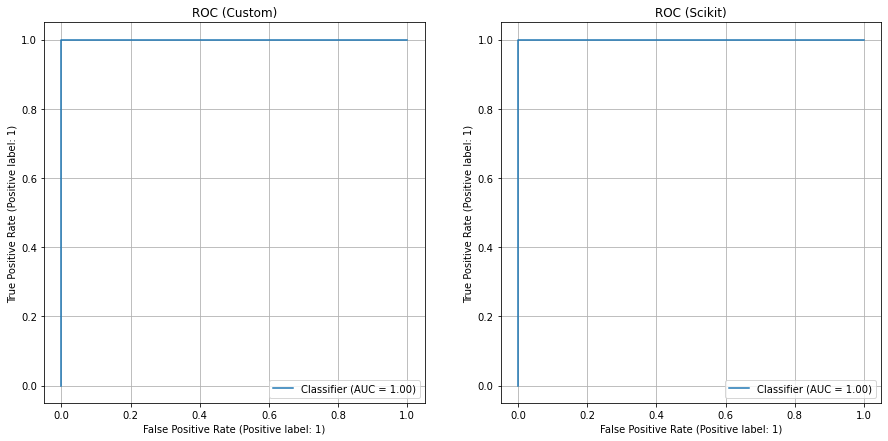

In [49]:
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_predict

data = syn2_data['train']
fig, axs = plt.subplots(1, 2, figsize=(15,7))
ax_c, ax_s = axs

predictions_c = custom_model_syn2.decision_function(data['x'])
predictions_s = scikit_model_syn2.decision_function(data['x'])

RocCurveDisplay.from_predictions(data['y'], predictions_c, ax=ax_c)
RocCurveDisplay.from_predictions(data['y'], predictions_s, ax=ax_s)

ax_c.set_title('ROC (Custom)')
ax_s.set_title('ROC (Scikit)');

ax_c.grid()
ax_s.grid()

#### Czasy

In [50]:
from sklearn.linear_model import RidgeClassifier
from sklearn.base import clone
import timeit

custom_model_time = clone(custom_model_syn1)
scikit_model_time = clone(scikit_model_syn1)

def time_custom_fit():
    custom_model_time.fit(syn2_data['train']['x'], syn2_data['train']['y'])

def time_custom_predict():
    custom_model_time.predict(syn2_data['test']['x'])

def time_scikit_fit():
    scikit_model_time.fit(syn2_data['train']['x'], syn2_data['train']['y'])

def time_scikit_predict():
    scikit_model_time.predict(syn2_data['test']['x'])


time_cf = timeit.timeit(time_custom_fit, number=1) / 1
time_cp = timeit.timeit(time_custom_predict, number=1000) / 1000
time_sf = timeit.timeit(time_scikit_fit, number=1000) / 1000
time_sp = timeit.timeit(time_scikit_predict, number=1000) / 1000

time_df = pd.DataFrame({'Nauka': [time_cf, time_sf], 'Przewidywanie': [time_cp, time_sp]}, index=['Custom', 'Scikit'])
time_df

,Nauka,Przewidywanie
Custom,13.422185,0.000067
Scikit,0.004787,0.000096


## Ocena 4

### Preprocessing

In [74]:
# Wczytywanie
weather_data = pd.read_csv('rainAUS.csv', na_values='NA', parse_dates=['Date'])

In [75]:
# Usuwanie kolumn z brakującymi wartościami
nan_percent = weather_data.isna().sum() / len(weather_data)
columns_to_drop = nan_percent.where(lambda x: x > 0.3).dropna().index.to_list()
weather_data.drop(columns_to_drop, axis='columns', inplace=True)

print('NaN percents:')
print(f'{nan_percent}\n')
print('Dropped columns:', columns_to_drop)

NaN percents:
Date             0.000000
Location         0.000000
MinTemp          0.010209
MaxTemp          0.008669
Rainfall         0.022419
Evaporation      0.431665
Sunshine         0.480098
WindGustDir      0.070989
WindGustSpeed    0.070555
WindDir9am       0.072639
WindDir3pm       0.029066
WindSpeed9am     0.012148
WindSpeed3pm     0.021050
Humidity9am      0.018246
Humidity3pm      0.030984
Pressure9am      0.103568
Pressure3pm      0.103314
Cloud9am         0.384216
Cloud3pm         0.408071
Temp9am          0.012148
Temp3pm          0.024811
RainToday        0.022419
RainTomorrow     0.022460
dtype: float64

Dropped columns: ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']


In [76]:
# Imputacja brakujących wartości
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

numeric_imputer = SimpleImputer(strategy='median')

categorical_imputer = SimpleImputer(strategy='most_frequent')

numeric_vars = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 
                'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 
                'Temp9am', 'Temp3pm']

categorical_vars = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

other_vars = ['Date', 'Location']

impute_pipe = ColumnTransformer([
        ('other', 'passthrough', other_vars),
        ('num_imp', numeric_imputer, numeric_vars),
        ('cat_imp', categorical_imputer, categorical_vars),
    ], remainder='passthrough')

transformed = impute_pipe.fit_transform(weather_data)

columns = other_vars + numeric_vars + categorical_vars
weather_data = pd.DataFrame(transformed, columns=columns)

# Optymalizacja typów
weather_data = weather_data.convert_dtypes(convert_integer=False)

weather_data.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
WindGustDir      0
WindDir9am       0
WindDir3pm       0
RainToday        0
RainTomorrow     0
dtype: int64

In [77]:
# Winsoryzacja
def winsorize(df, column_names):
    df_copy = df.copy()
    for column_name in column_names:
        column = df[column_name]
        q1 = column.quantile(0.25)
        q3 = column.quantile(0.75)
        iqr = q3 - q1
        limit_upper = q3 + 1.5*iqr
        limit_lower = q1 - 1.5*iqr
        df_copy[column_name].clip(limit_lower, limit_upper, inplace=True)
    return df_copy


weather_data = winsorize(weather_data, numeric_vars)

In [78]:
# Transformacja daty
weather_data['Year'] = weather_data.Date.dt.year
weather_data['DayOfYear'] = weather_data.Date.dt.day_of_year
weather_data.drop(columns=['Date'], inplace=True);

In [79]:
# Transformacja zmiennej przewidywanej do 0 / 1
weather_data['RainTomorrow'].replace({'Yes': 1, 'No': 0}, inplace=True)

In [80]:
# Podział na zbiory
from sklearn.model_selection import train_test_split

weather = {}

all_train_x = []
all_train_y = []
all_test_x = []
all_test_y = []

locations = weather_data['Location'].unique()

for location in locations:

    location_data = weather_data[weather_data['Location'] == location]
    location_x = location_data.drop(columns=['RainTomorrow', 'Location'])
    location_y = location_data['RainTomorrow']

    train_x, test_x, train_y, test_y = train_test_split(location_x, location_y, test_size=.2, random_state=seed, stratify=location_y)

    train_y = train_y.values
    test_y = test_y.values

    location_dict = {
        'train': {
            'x': train_x,
            'y': train_y,
        },
        'test': {
            'x': test_x,
            'y': test_y,
        },
    }

    weather[location] = location_dict

    all_train_x.append(train_x)
    all_train_y.append(train_y)
    all_test_x.append(test_x)
    all_test_y.append(test_y)

weather['all'] = {
    'train': {
        'x': pd.concat(all_train_x),
        'y': np.concatenate(all_train_y),
    },
    'test': {
        'x': pd.concat(all_test_x),
        'y': np.concatenate(all_test_y),
    }
}

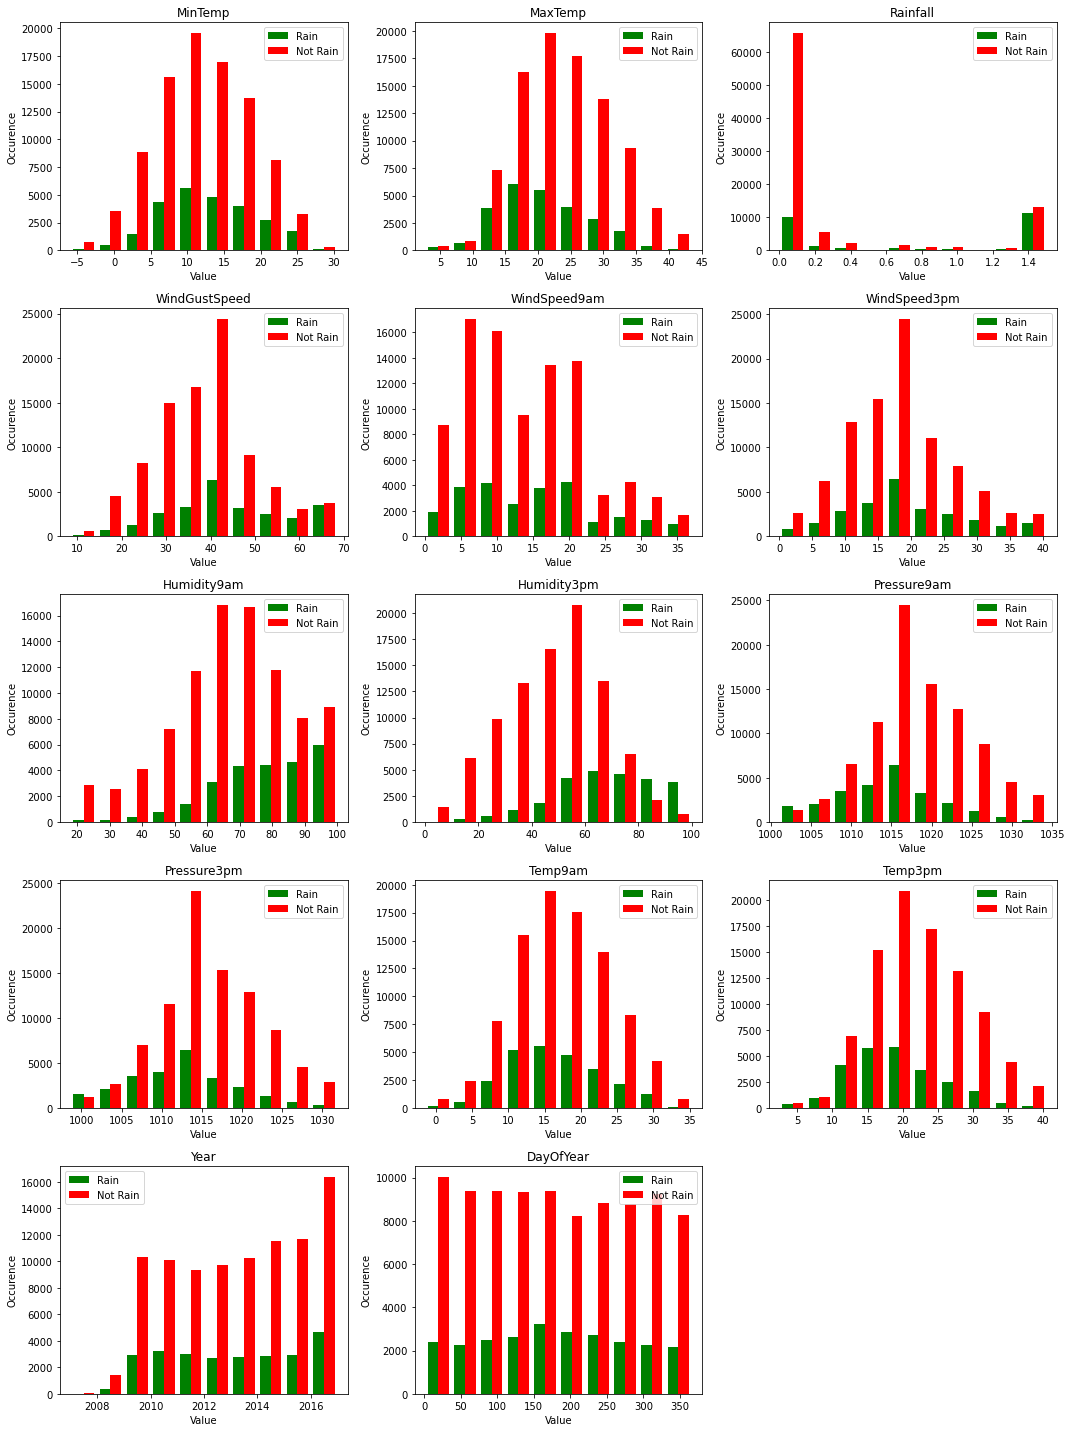

In [81]:
# Sprawdzenie rozkładów
fig, axs = plt.subplots(5, 3, figsize=(15, 20))
fig.delaxes(axs[4, 2])

bins_count = 10
columns = numeric_vars + ['Year', 'DayOfYear']

x = weather['all']['train']['x']
y = weather['all']['train']['y']

positive_data = x[y == 1]
negative_data = x[y == 0]

for i, column in enumerate(columns):
    ax = axs[i // 3][i % 3]
    ax.hist([positive_data[column], negative_data[column]], bins=bins_count, color=['g', 'r'], label=['Rain', 'Not Rain'])

    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Occurence')
    ax.legend()

fig.tight_layout()

In [82]:
# Normalizacja, standaryzacja, onehot
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

bin_vars = ['RainToday']
onehot_vars = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
standard_vars = ['MinTemp', 'MaxTemp', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
normal_vars = ['Rainfall', 'Year', 'DayOfYear']

dirs = ['N', 'E', 'S', 'W', 'NE', 'SE', 'SW', 'NW', 'NNE', 'ENE', 'ESE', 'SSE', 'SSW', 'WSW', 'WNW', 'NNW']

bin_transform = OrdinalEncoder()
hot_transform = OneHotEncoder(categories=[dirs, dirs, dirs])
std_transform = StandardScaler()
nor_transform = MinMaxScaler()

preprocess_pipeline = ColumnTransformer([
    ('bin', bin_transform, bin_vars),
    ('hot', hot_transform, onehot_vars),
    ('std', std_transform, standard_vars),
    ('nor', nor_transform, normal_vars),
])

preprocess_pipeline.fit_transform(weather['Katherine']['train']['x']);

### Nauka i testowanie wszystkich regionów

In [83]:
# Nauka
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, f1_score

scikit_model = make_pipeline(
    preprocess_pipeline,
    LogisticRegression(max_iter=10000),
)

scikit_models = {}

for location in locations:
    print(location, end=', ')
    model = clone(scikit_model)
    train_data = weather[location]['train']
    model.fit(train_data['x'], train_data['y'])
    scikit_models[location] = model

Albury, BadgerysCreek, Cobar, CoffsHarbour, Moree, Newcastle, NorahHead, NorfolkIsland, Penrith, Richmond, Sydney, SydneyAirport, WaggaWagga, Williamtown, Wollongong, Canberra, Tuggeranong, MountGinini, Ballarat, Bendigo, Sale, MelbourneAirport, Melbourne, Mildura, Nhil, Portland, Watsonia, Dartmoor, Brisbane, Cairns, GoldCoast, Townsville, Adelaide, MountGambier, Nuriootpa, Woomera, Albany, Witchcliffe, PearceRAAF, PerthAirport, Perth, SalmonGums, Walpole, Hobart, Launceston, AliceSprings, Darwin, Katherine, Uluru, 

In [99]:
# Metryki
from sklearn.metrics import recall_score, f1_score, accuracy_score

sens_list = []
spec_list = []
acc_list = []
f1_list = []

for location in locations:

    model = scikit_models[location]
    data = weather[location]['test']
    predictions = model.predict(data['x'])

    sens = recall_score(data['y'], predictions)
    spec = recall_score(data['y'], predictions, pos_label=0)
    f1 = f1_score(data['y'], predictions)
    acc = accuracy_score(data['y'], predictions)

    sens_list.append(sens)
    spec_list.append(spec)
    acc_list.append(acc)
    f1_list.append(f1)

df_data = {
    'Sensitivity': sens_list,
    'Specificity': spec_list,
    'F1': f1_list,
    'Accuracy': acc_list,
}
pd.DataFrame(df_data, index=locations).sort_values('Accuracy', ascending=False)

Największą skuteczność osiągnięto dla obszaru Uluru

### Porównanie klasyfikatora własnego i scikit

In [95]:
# Nauka
from sklearn.base import clone
from sklearn.pipeline import make_pipeline

location = 'Uluru'
train = weather[location]['train']
test = weather[location]['test']

scikit_model = clone(scikit_models[location])

custom_model = make_pipeline(
    preprocess_pipeline,
    CustomLogisticRegression(max_iter=200, tol=1e-10, learning_rate=1e-2),
)

scikit_model.fit(train['x'], train['y'])
custom_model.fit(train['x'], train['y']);

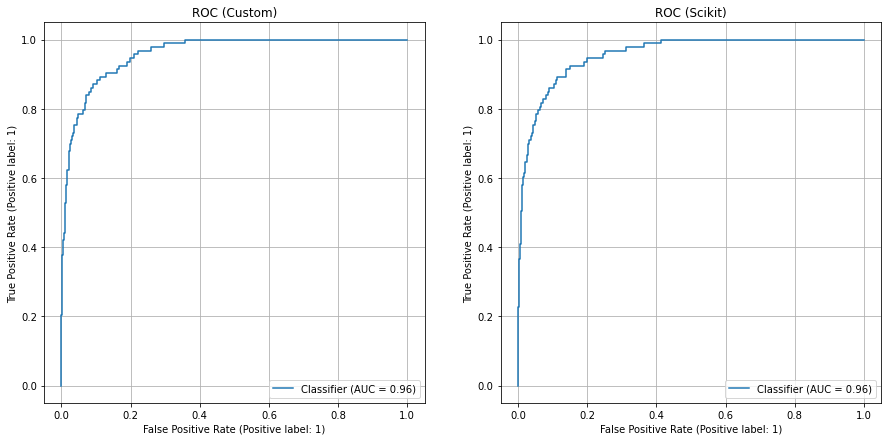

In [96]:
# Krzywe ROC
from sklearn.metrics import RocCurveDisplay

fig, axs = plt.subplots(1, 2, figsize=(15,7))
ax_c, ax_s = axs

predictions_c = custom_model.decision_function(train_x)
predictions_s = scikit_model.decision_function(train_x)

RocCurveDisplay.from_predictions(train_y, predictions_c, ax=ax_c)
RocCurveDisplay.from_predictions(train_y, predictions_s, ax=ax_s)

ax_c.set_title('ROC (Custom)')
ax_s.set_title('ROC (Scikit)');

ax_c.grid()
ax_s.grid()

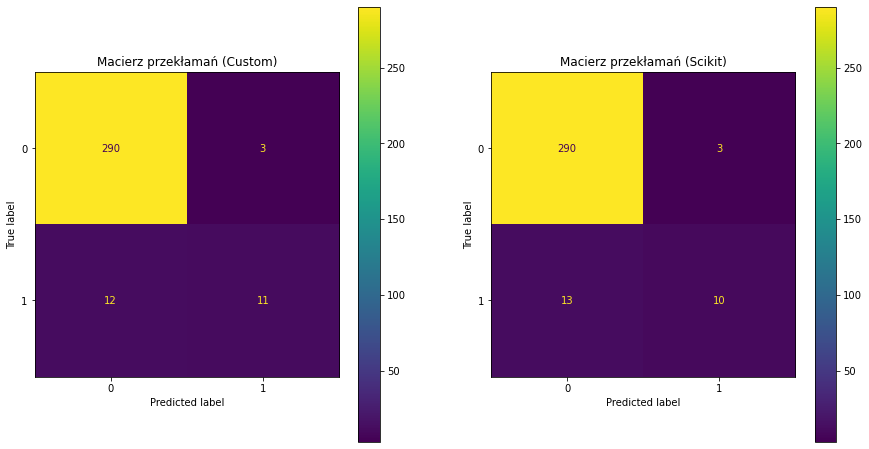

In [97]:
# Macierz przekłamań
from sklearn.metrics import ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 2, figsize=(15,8))
ax_c, ax_s = axs

custom_pred = custom_model.predict(test_x)
scikit_pred = scikit_model.predict(test_x)

ConfusionMatrixDisplay.from_predictions(test_y, custom_pred, ax=ax_c)
ConfusionMatrixDisplay.from_predictions(test_y, scikit_pred, ax=ax_s)

ax_c.set_title('Macierz przekłamań (Custom)')
ax_s.set_title('Macierz przekłamań (Scikit)');

In [100]:
# Metryki
from sklearn.metrics import recall_score, f1_score, accuracy_score

sens_list = []
spec_list = []
f1_list = []
acc_list = []

for model in [custom_model, scikit_model]:

    predictions = model.predict(test['x'])

    sens = recall_score(test['y'], predictions)
    spec = recall_score(test['y'], predictions, pos_label=0)
    f1 = f1_score(test['y'], predictions)
    acc = accuracy_score(test['y'], predictions)

    sens_list.append(sens)
    spec_list.append(spec)
    f1_list.append(f1)
    acc_list.append(acc)

pd.DataFrame({'Sensitivity': sens_list, 'Specificity': spec_list, 'F1': f1_list, 'Accuracy': acc_list}, index=['Custom', 'Scikit'])

,Sensitivity,Specificity,F1,Accuracy
Custom,0.478261,0.989761,0.594595,0.952532
Scikit,0.434783,0.989761,0.555556,0.949367


Własny klasyfikator okazał się nieco lepszy

In [101]:
# Pomiar czasów
from sklearn.linear_model import RidgeClassifier
from sklearn.base import clone
import timeit

custom_model_time = clone(custom_model)
scikit_model_time = clone(scikit_model)

def time_custom_fit():
    custom_model_time.fit(train_x, train_y)

def time_custom_predict():
    custom_model_time.predict(test_x)

def time_scikit_fit():
    scikit_model_time.fit(train_x, train_y)

def time_scikit_predict():
    scikit_model_time.predict(test_x)


time_cf = timeit.timeit(time_custom_fit, number=1) / 1
time_cp = timeit.timeit(time_custom_predict, number=100) / 100
time_sf = timeit.timeit(time_scikit_fit, number=100) / 100
time_sp = timeit.timeit(time_scikit_predict, number=100) / 100

time_df = pd.DataFrame({'Nauka': [time_cf, time_sf], 'Przewidywanie': [time_cp, time_sp]}, index=['Custom', 'Scikit'])
time_df

,Nauka,Przewidywanie
Custom,7.179330,0.005639
Scikit,0.026143,0.005703


Klasyfikator scikit uczy się dwa rzędy wielkości szybciej

## Ocena 5

### Testowanie modeli lokalnych na zbiorze krajowym

In [105]:
from sklearn.metrics import recall_score, f1_score, accuracy_score

sens_list = []
spec_list = []
f1_list = []
acc_list = []

test_data = weather['all']['test']

for location, model in scikit_models.items():

    predictions = model.predict(test_data['x'])

    sens = recall_score(test_data['y'], predictions)
    spec = recall_score(test_data['y'], predictions, pos_label=0)
    f1 = f1_score(test_data['y'], predictions)
    acc = accuracy_score(test_data['y'], predictions)

    sens_list.append(sens)
    spec_list.append(spec)
    f1_list.append(f1)
    acc_list.append(acc)

df_data = {
    'Sensitivity': sens_list,
    'Specificity': spec_list,
    'F1': f1_list,
    'Accuracy': acc_list,
}
pd.DataFrame(df_data, index=locations).sort_values('Accuracy', ascending=False)

,Sensitivity,Specificity,F1,Accuracy
Wollongong,0.389464,0.956480,0.504314,0.832217
Walpole,0.479931,0.930561,0.555687,0.831804
NorahHead,0.416275,0.943718,0.514934,0.828128
GoldCoast,0.437441,0.936546,0.525919,0.827166
Hobart,0.433992,0.934125,0.520154,0.824520
Richmond,0.508623,0.911155,0.557340,0.822939
Melbourne,0.359517,0.952783,0.470649,0.822767
Portland,0.443556,0.928229,0.522052,0.822011
Woomera,0.412512,0.934829,0.501621,0.820362
BadgerysCreek,0.505488,0.908471,0.551960,0.820156


Największą skuteczność osiągniął klasyfikator lokalny uczony dla lokalizacji Wollongong.


Klasyfikator ten nie miał największej skuteczności lokalnej (był w połowie stawki).

### Porównanie najlepszego modelu krajowego z DummyClassifier

In [106]:
# Nauka
from sklearn.dummy import DummyClassifier

all_test = weather['all']['test']

best_country_model = scikit_models['Wollongong']

dummy_model = DummyClassifier()
dummy_model.fit(all_test['x'], all_test['y']);

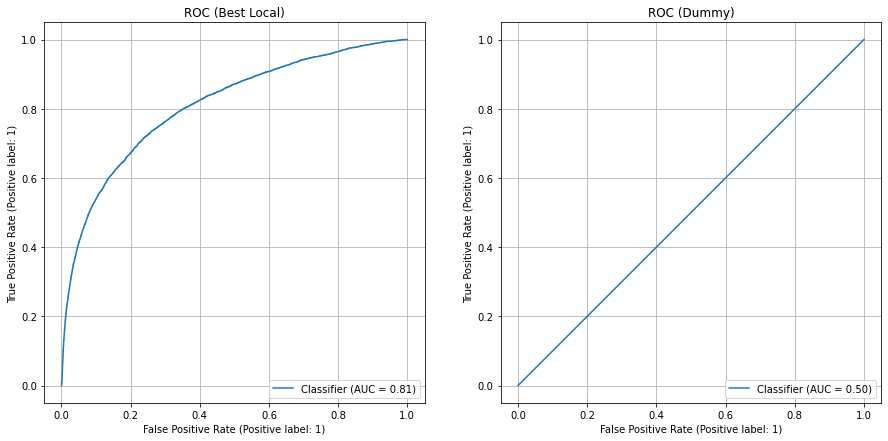

In [122]:
# Krzywe ROC
from sklearn.metrics import RocCurveDisplay

fig, axs = plt.subplots(1, 2, figsize=(15,7))
ax_c, ax_s = axs

predictions_b = best_country_model.decision_function(all_test['x'])
predictions_d = dummy_model.predict_proba(all_test['x'])[:, 0]

RocCurveDisplay.from_predictions(all_test['y'], predictions_b, ax=ax_c)
RocCurveDisplay.from_predictions(all_test['y'], predictions_d, ax=ax_s)

ax_c.set_title('ROC (Best Local)')
ax_s.set_title('ROC (Dummy)');

ax_c.grid()
ax_s.grid()

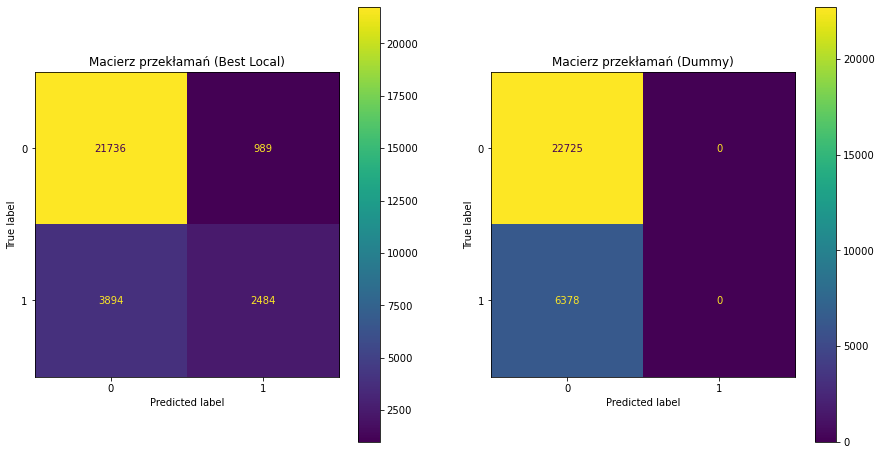

In [121]:
# Macierz przekłamań
from sklearn.metrics import ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 2, figsize=(15,8))
ax_c, ax_s = axs

best_pred = best_country_model.predict(all_test['x'])
dummy_pred = dummy_model.predict(all_test['x'])

ConfusionMatrixDisplay.from_predictions(all_test['y'], best_pred, ax=ax_c)
ConfusionMatrixDisplay.from_predictions(all_test['y'], dummy_pred, ax=ax_s)

ax_c.set_title('Macierz przekłamań (Best Local)')
ax_s.set_title('Macierz przekłamań (Dummy)');

Dummy classifier zawsze przewiduje, że deszcz nie pada

In [117]:
# Metryki
from sklearn.metrics import recall_score, f1_score, accuracy_score

sens_list = []
spec_list = []
f1_list = []
acc_list = []

for model in [best_country_model, dummy_model]:

    predictions = model.predict(all_test['x'])

    sens = recall_score(all_test['y'], predictions)
    spec = recall_score(all_test['y'], predictions, pos_label=0)
    f1 = f1_score(all_test['y'], predictions)
    acc = accuracy_score(all_test['y'], predictions)

    sens_list.append(sens)
    spec_list.append(spec)
    f1_list.append(f1)
    acc_list.append(acc)

pd.DataFrame({'Sensitivity': sens_list, 'Specificity': spec_list, 'F1': f1_list, 'Accuracy': acc_list}, index=['Logistic', 'Dummy'])

,Sensitivity,Specificity,F1,Accuracy
Logistic,0.389464,0.95648,0.504314,0.832217
Dummy,0.000000,1.00000,0.000000,0.780847


In [118]:
# Pomiar czasów
from sklearn.linear_model import RidgeClassifier
from sklearn.base import clone
import timeit

best_country_model_time = clone(best_country_model)
dummy_model_time = clone(dummy_model)

def time_custom_fit():
    best_country_model_time.fit(train_x, train_y)

def time_custom_predict():
    best_country_model_time.predict(test_x)

def time_scikit_fit():
    dummy_model_time.fit(train_x, train_y)

def time_scikit_predict():
    dummy_model_time.predict(test_x)


time_cf = timeit.timeit(time_custom_fit, number=100) / 100
time_cp = timeit.timeit(time_custom_predict, number=100) / 100
time_sf = timeit.timeit(time_scikit_fit, number=100) / 100
time_sp = timeit.timeit(time_scikit_predict, number=100) / 100

time_df = pd.DataFrame({'Nauka': [time_cf, time_sf], 'Przewidywanie': [time_cp, time_sp]}, index=['Custom', 'Scikit'])
time_df

,Nauka,Przewidywanie
Custom,0.026794,0.005827
Scikit,0.000072,0.000025


Model scikit uczy się o trzy rzędy wielkości szybciej i przewiduje 2 rzędy wielkości szybciej

Budowanie modeli w oparciu o dane fragmentaryczne to zwykle zły pomysł, ponieważ model uczy się wzorców charakterystycznych dla fragmentarycznych danych, które nie muszą być prawidłowe dla szerszego zbioru.